# Comparación de predicciones de series de tiempo de muertes por COVID-19

In [1]:
import pmdarima as pm
import pandas as pd
import numpy as np
import itertools
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline
plt.style.use('fivethirtyeight')

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from sklearn.svm import SVR
from xgboost import XGBRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

## Preparación del dataset

In [2]:
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
deaths_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21,1/21/21,1/22/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,2301,2314,2324,2336,2339,2343,2346,2354,2363,2370
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,1256,1261,1265,1270,1277,1281,1287,1291,1296,1303
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,2819,2822,2827,2831,2836,2840,2843,2849,2853,2856
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,87,88,88,91,91,91,92,92,93,93
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,424,425,428,431,436,439,442,444,448,452


In [3]:
d = deaths_df.loc[:, '1/22/20':]
d = d.transpose()
d = d.sum(axis=1)
d = d.to_list()
dataset = pd.DataFrame(columns=['ds', 'y'])
dates = list(deaths_df.columns[4:])
dates = list(pd.to_datetime(dates))
dataset['ds'] = dates
dataset['y'] = d
dataset = dataset.set_index('ds')
dataset.head()

,y
ds,
2020-01-22,17
2020-01-23,18
2020-01-24,26
2020-01-25,42
2020-01-26,56


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 367 entries, 2020-01-22 to 2021-01-22
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   y       367 non-null    int64
dtypes: int64(1)
memory usage: 5.7 KB


Text(0.5, 1.0, 'Muertes acumuladas COVID19')

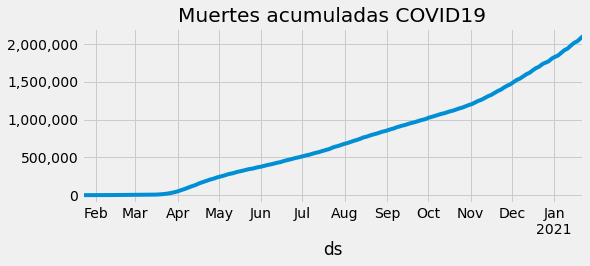

In [5]:
ax = dataset.plot(figsize=(8, 3), legend = None)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_title('Muertes acumuladas COVID19')

In [6]:
# Incremento diario. Para hacerlo utilizo el método diff del objeto DataFrame

dataset = dataset.diff()
dataset = dataset.loc['2020-01-23':]
dataset.head()

,y
ds,
2020-01-23,1.0
2020-01-24,8.0
2020-01-25,16.0
2020-01-26,14.0
2020-01-27,26.0


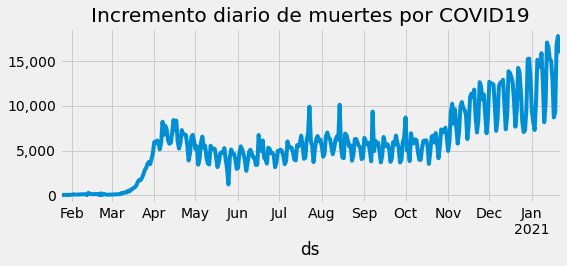

In [7]:
ax = dataset.plot(figsize=(8, 3), legend = None)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_title('Incremento diario de muertes por COVID19');

In [8]:
dataset.describe()

,y
count,366.000000
mean,5757.833333
std,3820.064403
min,1.000000
25%,3828.750000
50%,5467.500000
75%,7050.250000
max,17817.000000


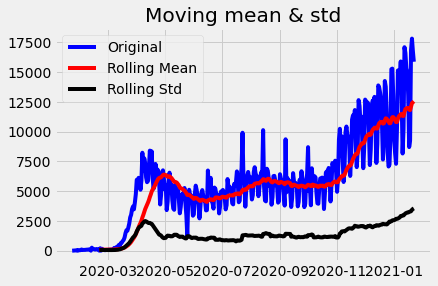

(-0.4841620243960042, 0.8950702907569746, 14, 351, {'1%': -3.44911857009962, '5%': -2.8698097654570507, '10%': -2.5711757061225153}, 5756.761097483377)
Test Statistic                  -0.484162
p-value                          0.895070
#Lags Used                      14.000000
Number of Observations Used    351.000000
Critical Value (1%)             -3.449119
Critical Value (5%)             -2.869810
Critical Value (10%)            -2.571176
dtype: float64


In [9]:
# Determing rolling statistics
rol_mean = dataset.rolling(window  = 30).mean()
rol_std = dataset.rolling(window = 30).std()

# Plot rolling statistics:
orig = plt.plot(dataset, color = 'blue',label = 'Original')
mean = plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
std = plt.plot(rol_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Moving mean & std')
plt.show(block = False)

# Perform Dickey-Fuller test:
test = adfuller(dataset, autolag = 'AIC')
print(test)

# to make the results of the test more readable
dfoutput = pd.Series(test[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in test[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

## Predicción con SARIMAX (Seasonal AutoRegressive Integrated Moving Average with exogenous regressors)

#### Determinar p, q y d

In [10]:
# Diferenciación (d)

dataset_diff = dataset.copy()
dataset_diff = dataset_diff.diff()
dataset_diff = dataset_diff.loc['2020-01-24':]

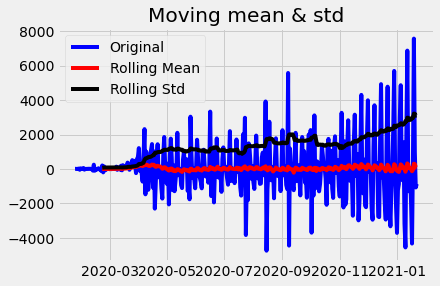

(-4.281860433661137, 0.0004774624917601468, 13, 351, {'1%': -3.44911857009962, '5%': -2.8698097654570507, '10%': -2.5711757061225153}, 5739.576026542204)
Test Statistic                  -4.281860
p-value                          0.000477
#Lags Used                      13.000000
Number of Observations Used    351.000000
Critical Value (1%)             -3.449119
Critical Value (5%)             -2.869810
Critical Value (10%)            -2.571176
dtype: float64


In [11]:
# Determing rolling statistics
rol_mean = dataset_diff.rolling(window  = 30).mean()
rol_std = dataset_diff.rolling(window = 30).std()

# Plot rolling statistics:
orig = plt.plot(dataset_diff, color = 'blue',label = 'Original')
mean = plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
std = plt.plot(rol_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Moving mean & std')
plt.show(block = False)

# Perform Dickey-Fuller test:
test = adfuller(dataset_diff, autolag = 'AIC')
print(test)

# to make the results of the test more readable
dfoutput = pd.Series(test[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in test[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

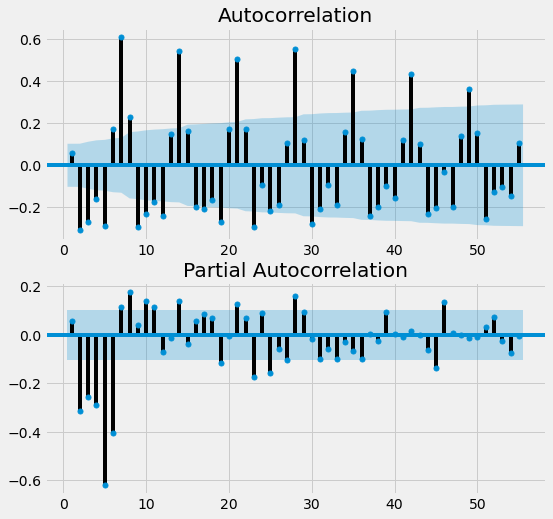

In [12]:
# Non seasonal model orders

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

# Plot the ACF of savings on ax1
plot_acf(dataset_diff.y, lags = 55, zero = False, ax = ax1);

# Plot the PACF of savings on ax2
plot_pacf(dataset_diff.y, lags = 55, zero = False, ax = ax2);

#### División dataset en train y test sets

In [13]:
train, test = train_test_split(dataset, test_size=12, random_state=42, shuffle=False)
display(train)
display(test)

,y
ds,
2020-01-23,1.0
2020-01-24,8.0
2020-01-25,16.0
2020-01-26,14.0
2020-01-27,26.0
...,...
2021-01-06,15016.0
2021-01-07,14354.0
2021-01-08,15898.0


,y
ds,
2021-01-11,10228.0
2021-01-12,17096.0
2021-01-13,16612.0
2021-01-14,15313.0
2021-01-15,15038.0
2021-01-16,13033.0
2021-01-17,8706.0
2021-01-18,9276.0
2021-01-19,16840.0


In [14]:
# buscar la mejor combinación de hiperparámetros con auto_arima

model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',          # use adftest to find optimal 'd'
                      max_p=10, max_q=10,  # maximum p and q
                      m=1,                 # frequency of series
                      d=None,              # let model determine 'd'
                      seasonal=False,      # No Seasonality
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=False)

print(model.summary())

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6148.345, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6149.166, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6068.330, Time=0.67 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6052.348, Time=0.81 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=6021.985, Time=0.94 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=6011.609, Time=1.32 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6149.706, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6090.357, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6062.106, Time=0.88 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6049.682, Time=1.08 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=6004.478, Time=1.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6127.717, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6033.083, Time=0.87 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5938.396, Time=1.16 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5944.819, Time=1.19 sec
 ARIMA(3,1

In [15]:
model = SARIMAX(train, order=(5, 1, 0))
results = model.fit(disp = True)

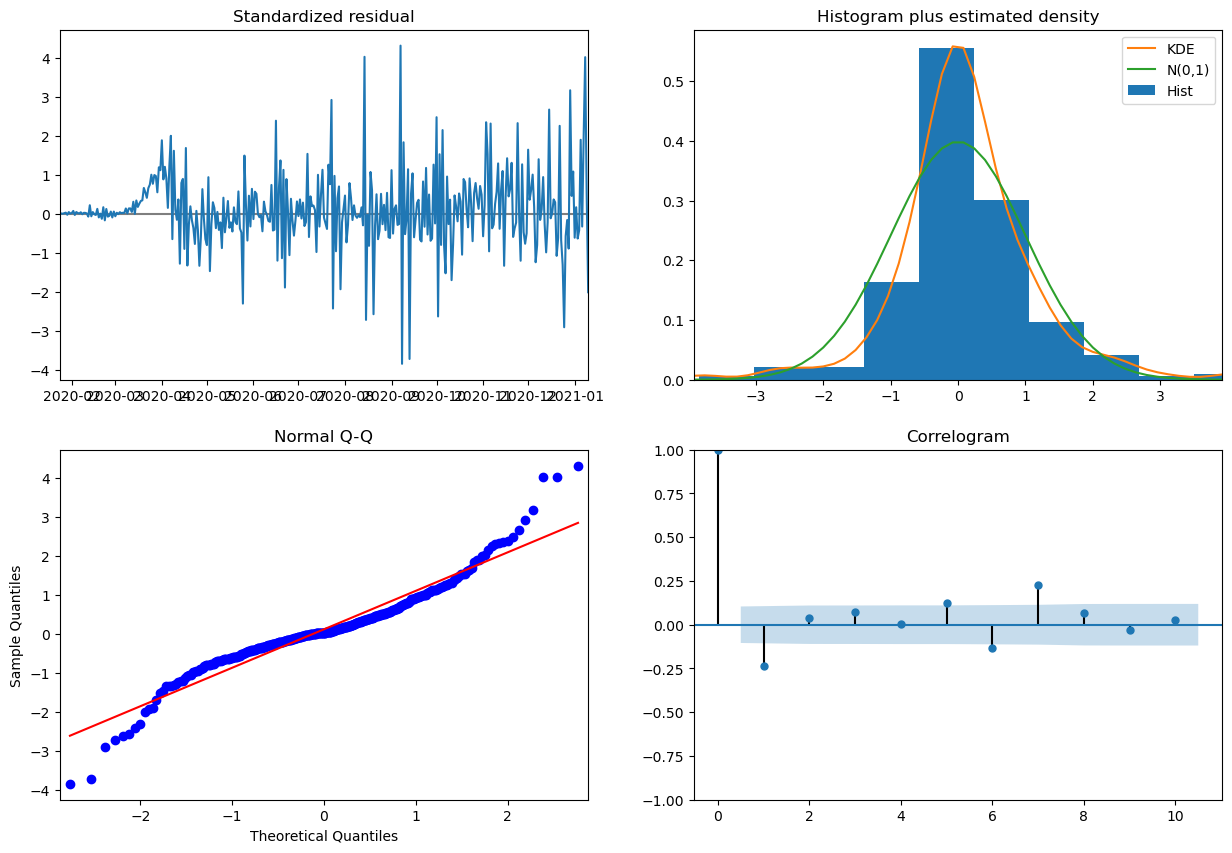

In [16]:
# ARIMA Model Evaluation

plt.rcParams.update(plt.rcParamsDefault)
results.plot_diagnostics(figsize = (15, 10));

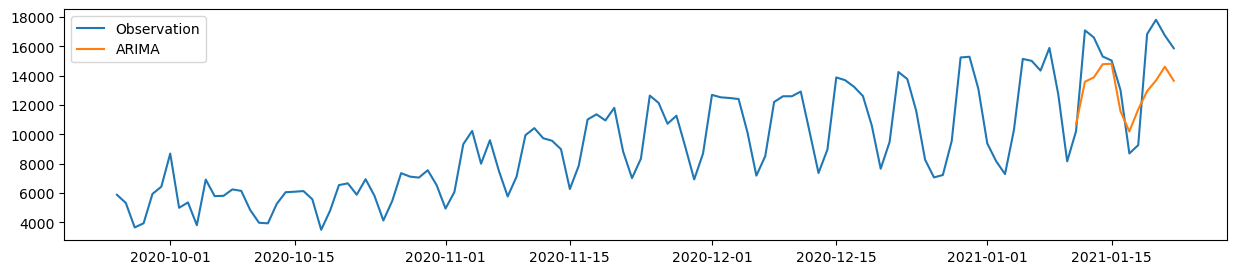

In [17]:
sarimax_prediction = results.predict(start = test.index[0], end = test.index[-1], dynamic = False)
plt.figure(figsize=(15, 3))
l1, = plt.plot(dataset.tail(120), label = 'Observation')
l2, = plt.plot(sarimax_prediction, label = 'ARIMA')
plt.legend(handles = [l1, l2])

In [18]:
print('SARIMAX RMSE = ', sqrt(mean_squared_error(sarimax_prediction, test)))

SARIMAX RMSE =  2451.5451732950696


## Predicción con Facebook Prophet

In [19]:
train['ds'] = train.index.values

In [20]:
# Hyperparameter - Optimization

def create_param_combinations(**param_dict):
    param_iter = itertools.product(*param_dict.values())
    params =[]
    for param in param_iter:
        params.append(param) 
    params_df = pd.DataFrame(params, columns=list(param_dict.keys()))
    return params_df

def single_cv_run(history_df, metrics, param_dict):
    m = Prophet(**param_dict)
    m.fit(history_df)
    df_cv = cross_validation(m, initial='50 days', period='50 days', horizon = '50 days')
    df_p = performance_metrics(df_cv).mean().to_frame().T
    df_p['params'] = str(param_dict)
    df_p = df_p.loc[:, metrics]
    return df_p

param_grid = {  
                'changepoint_prior_scale': [0.001,0.01,0.05,0.5],
                'changepoint_range': [0.8, 0.9]
              }

metrics = ['horizon', 'rmse', 'mape', 'params'] 

results = []


params_df = create_param_combinations(**param_grid)
for param in params_df.values:
    param_dict = dict(zip(params_df.keys(), param))
    cv_df = single_cv_run(train,  metrics, param_dict)
    results.append(cv_df)
results_df = pd.concat(results).reset_index(drop=True)
best_param = results_df.loc[results_df['rmse'] == min(results_df['rmse']), ['params']]
print(f'\n The best param combination is {best_param.values[0][0]}')
results_df

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-03-16 00:00:00 and 2020-11-21 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-03-16 00:00:00 and 2020-11-21 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-03-16 00:00:00 and 2020-11-21 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-03-16 00:00:00 and 2020-11-21 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-03-16 00:00:00 and 2020-11-21 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-03-16 00:00:00 and 2020-11-21 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-03-16 00:00:00 and 2020-11-21 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-03-16 00:00:00 and 2020-11-21 00:00:00




 The best param combination is {'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8}


,horizon,rmse,mape,params
0,27 days 12:00:00,3326.03,0.572556,"{'changepoint_prior_scale': 0.001, 'changepoin..."
1,27 days 12:00:00,3327.65,0.57322,"{'changepoint_prior_scale': 0.001, 'changepoin..."
2,27 days 12:00:00,3091.72,0.495683,"{'changepoint_prior_scale': 0.01, 'changepoint..."
3,27 days 12:00:00,3092.34,0.496246,"{'changepoint_prior_scale': 0.01, 'changepoint..."
4,27 days 12:00:00,3347.32,0.474829,"{'changepoint_prior_scale': 0.05, 'changepoint..."
5,27 days 12:00:00,3314.23,0.472299,"{'changepoint_prior_scale': 0.05, 'changepoint..."
6,27 days 12:00:00,2332.44,0.326377,"{'changepoint_prior_scale': 0.5, 'changepoint_..."
7,27 days 12:00:00,2548.66,0.328694,"{'changepoint_prior_scale': 0.5, 'changepoint_..."


In [21]:
m = Prophet(changepoint_prior_scale = 0.5, changepoint_range = 0.8)
m.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [22]:
future = m.make_future_dataframe(periods = dataset.shape[0] - train.shape[0])
prophet_prediction = m.predict(future)

In [23]:
prophet_prediction = prophet_prediction.set_index('ds')
prophet_future = prophet_prediction.yhat.loc[prophet_prediction.index >= test.index[0]]

In [24]:
print('PROPHET RMSE = ', sqrt(mean_squared_error(prophet_future, test)))

PROPHET RMSE =  2416.408335627667


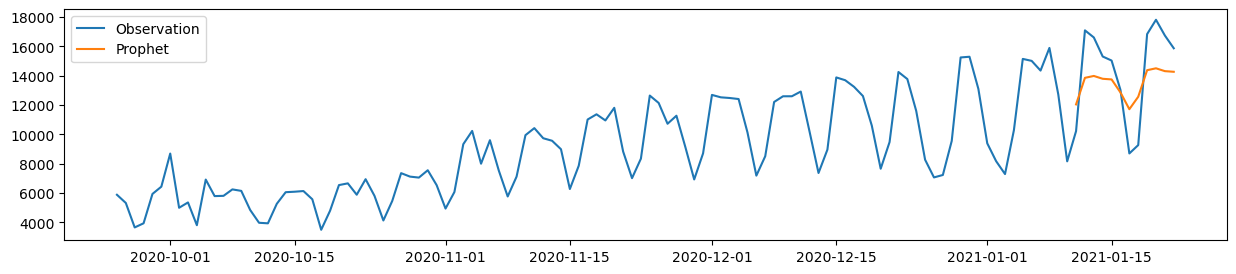

In [25]:
plt.figure(figsize=(15, 3))
l1, = plt.plot(dataset.tail(120), label = 'Observation')
l2, = plt.plot(prophet_future, label = 'Prophet')
plt.legend(handles=[l1, l2])

## Preparación del dataset para XGBoost y NN

In [26]:
# Función que extrae los features del dataset

def featurize(t):
    X = pd.DataFrame()

    X['day'] = t.index.day
    X['month'] = t.index.month
    X['quarter'] = t.index.quarter
    X['dayofweek'] = t.index.dayofweek
    X['dayofyear'] = t.index.dayofyear
    X['weekofyear'] = t.index.weekofyear
    y = t.y
    return X, y

featurize(dataset_diff)[0].head()

,day,month,quarter,dayofweek,dayofyear,weekofyear
0,24,1,1,4,24,4
1,25,1,1,5,25,4
2,26,1,1,6,26,4
3,27,1,1,0,27,5
4,28,1,1,1,28,5


#### Creación de training and test datasets dividiendo el dataset y estandarizar los datos

In [27]:
X_train, y_train = featurize(dataset_diff.loc[dataset_diff.index < test.index[0]])
X_test, y_test = featurize(dataset_diff.loc[dataset_diff.index >= test.index[0]])

In [28]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [29]:
scaled_train = scaler.transform(X_train)
scaled_test = scaler.transform(X_test)

## Predicción con XGBOOST

In [30]:
tscv = TimeSeriesSplit(n_splits=12)

In [31]:
# Use scikit-learn to grid search the max_depth & n_estimators

model = XGBRegressor()
n_estimators = [2, 3, 5, 7, 8, 9, 10]
max_depth = [2, 4, 6, 8]
param_grid = dict(max_depth = max_depth, n_estimators = n_estimators)
grid = GridSearchCV(model, param_grid, scoring = 'r2', n_jobs = -1, cv = tscv, verbose = 1)
grid_result = grid.fit(scaled_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 12 folds for each of 28 candidates, totalling 336 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.6s


Best: 0.190594 using {'max_depth': 4, 'n_estimators': 3}
0.140561 (0.179875) with: {'max_depth': 2, 'n_estimators': 2}
0.162891 (0.257726) with: {'max_depth': 2, 'n_estimators': 3}
0.183866 (0.353676) with: {'max_depth': 2, 'n_estimators': 5}
0.182801 (0.408520) with: {'max_depth': 2, 'n_estimators': 7}
0.171190 (0.417466) with: {'max_depth': 2, 'n_estimators': 8}
0.148514 (0.444630) with: {'max_depth': 2, 'n_estimators': 9}
0.144930 (0.476864) with: {'max_depth': 2, 'n_estimators': 10}
0.157342 (0.248657) with: {'max_depth': 4, 'n_estimators': 2}
0.190594 (0.277203) with: {'max_depth': 4, 'n_estimators': 3}
0.187142 (0.377228) with: {'max_depth': 4, 'n_estimators': 5}
0.173998 (0.417890) with: {'max_depth': 4, 'n_estimators': 7}
0.161755 (0.440211) with: {'max_depth': 4, 'n_estimators': 8}
0.142535 (0.457237) with: {'max_depth': 4, 'n_estimators': 9}
0.115372 (0.477763) with: {'max_depth': 4, 'n_estimators': 10}
0.145403 (0.242793) with: {'max_depth': 6, 'n_estimators': 2}
0.148186 (0

[Parallel(n_jobs=-1)]: Done 336 out of 336 | elapsed:    7.7s finished


In [32]:
XGBOOST_prediction = grid.predict(scaled_test)

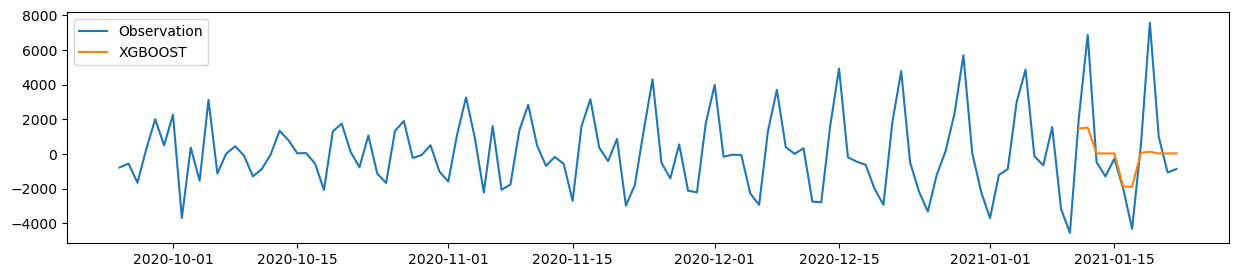

In [33]:
XGBOOST_prediction = pd.DataFrame(XGBOOST_prediction, index = test.index, columns = test.columns)
plt.figure(figsize=(15, 3))
l1, = plt.plot(dataset_diff.tail(120), label = 'Observation')
l2, = plt.plot(XGBOOST_prediction, label = 'XGBOOST')
plt.legend(handles=[l1, l2])

In [34]:
print('XGBOOST RMSE = ', sqrt(mean_squared_error(XGBOOST_prediction, y_test)))

XGBOOST RMSE =  2822.229509624964


## Predicción con NN

In [35]:
NN_model = Sequential()
NN_model.add(Dense(20, input_shape = (scaled_train.shape[1],)))
NN_model.add(Dense(10))
NN_model.add(Dense(1))
NN_model.compile(loss='mean_squared_error', optimizer = Adam(lr = 0.001))
NN_model.fit(scaled_train, y_train, validation_data = (scaled_test, y_test), epochs = 360, verbose = 1)
NN_prediction = NN_model.predict(scaled_test)

Epoch 1/360
12/12 [==============================] - 0s 20ms/step - loss: 2123653.0000 - val_loss: 11383176.0000
Epoch 2/360
12/12 [==============================] - 0s 4ms/step - loss: 2123266.0000 - val_loss: 11382136.0000
Epoch 3/360
12/12 [==============================] - 0s 4ms/step - loss: 2122920.0000 - val_loss: 11381224.0000
Epoch 4/360
12/12 [==============================] - 0s 4ms/step - loss: 2122585.5000 - val_loss: 11380008.0000
Epoch 5/360
12/12 [==============================] - 0s 3ms/step - loss: 2122293.0000 - val_loss: 11378849.0000
Epoch 6/360
12/12 [==============================] - 0s 4ms/step - loss: 2122024.5000 - val_loss: 11377843.0000
Epoch 7/360
12/12 [==============================] - 0s 4ms/step - loss: 2121719.0000 - val_loss: 11377196.0000
Epoch 8/360
12/12 [==============================] - 0s 5ms/step - loss: 2121400.7500 - val_loss: 11376472.0000
Epoch 9/360
12/12 [==============================] - 0s 4ms/step - loss: 2121021.5000 - val_loss: 11375

12/12 [==============================] - 0s 3ms/step - loss: 1711636.1250 - val_loss: 10077159.0000
Epoch 74/360
12/12 [==============================] - 0s 4ms/step - loss: 1702066.3750 - val_loss: 10036831.0000
Epoch 75/360
12/12 [==============================] - 0s 3ms/step - loss: 1692581.3750 - val_loss: 9992884.0000
Epoch 76/360
12/12 [==============================] - 0s 3ms/step - loss: 1682892.3750 - val_loss: 9952351.0000
Epoch 77/360
12/12 [==============================] - 0s 3ms/step - loss: 1673436.2500 - val_loss: 9906862.0000
Epoch 78/360
12/12 [==============================] - 0s 3ms/step - loss: 1664711.7500 - val_loss: 9860355.0000
Epoch 79/360
12/12 [==============================] - 0s 3ms/step - loss: 1655253.7500 - val_loss: 9813757.0000
Epoch 80/360
12/12 [==============================] - 0s 3ms/step - loss: 1646018.5000 - val_loss: 9767218.0000
Epoch 81/360
12/12 [==============================] - 0s 3ms/step - loss: 1637034.3750 - val_loss: 9722123.0000
Epo

12/12 [==============================] - 0s 3ms/step - loss: 1462309.8750 - val_loss: 8175280.5000
Epoch 146/360
12/12 [==============================] - 0s 3ms/step - loss: 1462318.0000 - val_loss: 8171755.5000
Epoch 147/360
12/12 [==============================] - 0s 3ms/step - loss: 1462365.3750 - val_loss: 8164274.5000
Epoch 148/360
12/12 [==============================] - 0s 3ms/step - loss: 1462052.6250 - val_loss: 8155919.5000
Epoch 149/360
12/12 [==============================] - 0s 3ms/step - loss: 1462496.5000 - val_loss: 8144132.0000
Epoch 150/360
12/12 [==============================] - 0s 3ms/step - loss: 1462106.0000 - val_loss: 8158202.5000
Epoch 151/360
12/12 [==============================] - 0s 3ms/step - loss: 1461597.7500 - val_loss: 8201324.0000
Epoch 152/360
12/12 [==============================] - 0s 3ms/step - loss: 1461608.2500 - val_loss: 8216392.0000
Epoch 153/360
12/12 [==============================] - 0s 3ms/step - loss: 1461730.1250 - val_loss: 8227658.50

12/12 [==============================] - 0s 4ms/step - loss: 1460565.6250 - val_loss: 8197334.5000
Epoch 218/360
12/12 [==============================] - 0s 3ms/step - loss: 1460438.6250 - val_loss: 8197857.5000
Epoch 219/360
12/12 [==============================] - 0s 3ms/step - loss: 1460473.2500 - val_loss: 8196230.0000
Epoch 220/360
12/12 [==============================] - 0s 3ms/step - loss: 1460336.6250 - val_loss: 8193435.5000
Epoch 221/360
12/12 [==============================] - 0s 3ms/step - loss: 1460493.3750 - val_loss: 8189220.0000
Epoch 222/360
12/12 [==============================] - 0s 3ms/step - loss: 1460462.8750 - val_loss: 8175820.0000
Epoch 223/360
12/12 [==============================] - 0s 3ms/step - loss: 1460624.7500 - val_loss: 8148033.5000
Epoch 224/360
12/12 [==============================] - 0s 3ms/step - loss: 1460891.0000 - val_loss: 8138989.5000
Epoch 225/360
12/12 [==============================] - 0s 3ms/step - loss: 1460614.8750 - val_loss: 8136974.50

12/12 [==============================] - 0s 4ms/step - loss: 1459210.1250 - val_loss: 8221186.5000
Epoch 290/360
12/12 [==============================] - 0s 4ms/step - loss: 1459224.5000 - val_loss: 8222948.0000
Epoch 291/360
12/12 [==============================] - 0s 5ms/step - loss: 1459157.3750 - val_loss: 8225364.5000
Epoch 292/360
12/12 [==============================] - 0s 3ms/step - loss: 1459249.0000 - val_loss: 8226012.0000
Epoch 293/360
12/12 [==============================] - 0s 3ms/step - loss: 1459104.1250 - val_loss: 8225553.5000
Epoch 294/360
12/12 [==============================] - 0s 3ms/step - loss: 1459202.8750 - val_loss: 8228237.5000
Epoch 295/360
12/12 [==============================] - 0s 3ms/step - loss: 1459180.6250 - val_loss: 8236380.5000
Epoch 296/360
12/12 [==============================] - 0s 4ms/step - loss: 1459236.1250 - val_loss: 8245025.5000
Epoch 297/360
12/12 [==============================] - 0s 4ms/step - loss: 1459288.1250 - val_loss: 8253739.50

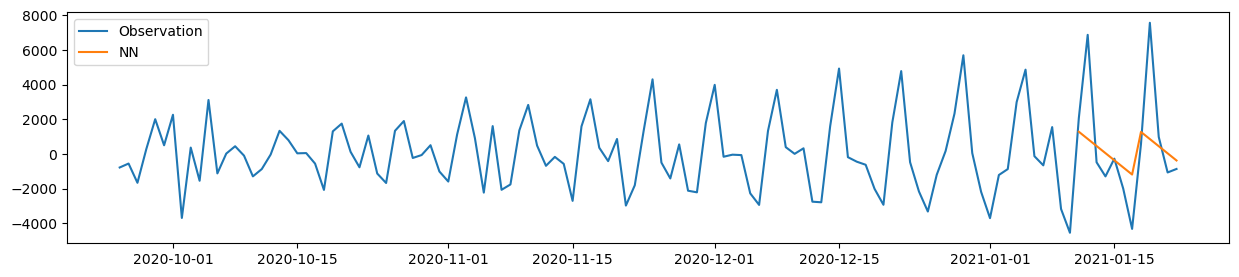

In [36]:
NN_prediction = pd.DataFrame(NN_prediction, index = test.index, columns = test.columns)
plt.figure(figsize=(15, 3))
l1, = plt.plot(dataset_diff.tail(120), label = 'Observation')
l2, = plt.plot(NN_prediction, label = 'NN')
plt.legend(handles=[l1, l2])

In [37]:
print('NN RMSE = ', sqrt(mean_squared_error(NN_prediction, y_test)))

NN RMSE =  2856.3676311445515


## Comparación de los RMSE de cada modelo

In [38]:
df_results = pd.DataFrame(columns = ['Model', 'RMSE'])
df_results.loc[0, 'Model'] = 'SARIMAX'
df_results.loc[0, 'RMSE'] = round(sqrt(mean_squared_error(sarimax_prediction, test)),4)
df_results.loc[1, 'Model'] = 'Prophet'
df_results.loc[1, 'RMSE'] = round(sqrt(mean_squared_error(prophet_future, test)),4)
df_results.loc[2, 'Model'] = 'XGBOOST'
df_results.loc[2, 'RMSE'] = round(sqrt(mean_squared_error(XGBOOST_prediction, y_test)),4)
df_results.loc[3, 'Model'] = 'NN'
df_results.loc[3, 'RMSE'] = round(sqrt(mean_squared_error(NN_prediction, y_test)),4)
df_results.sort_values(by = 'RMSE', ascending = True)

,Model,RMSE
1,Prophet,2416.41
0,SARIMAX,2451.55
2,XGBOOST,2822.23
3,NN,2856.37


## Visualización de las predicciones de cada modelo

<Figure size 2600x2300 with 0 Axes>

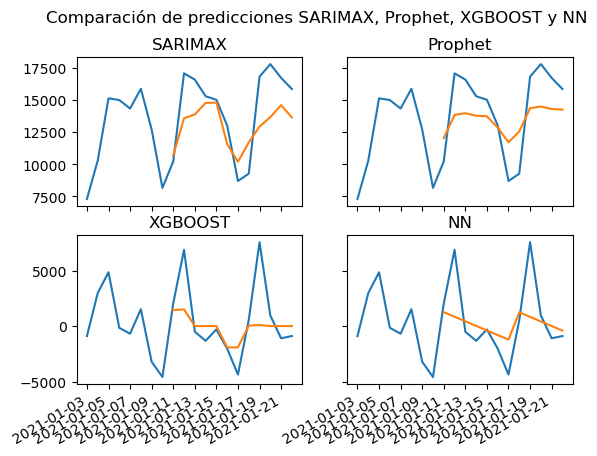

In [39]:
plt.figure(figsize=(26, 23))
fig, axs = plt.subplots(2, 2)
fig.suptitle('Comparación de predicciones SARIMAX, Prophet, XGBOOST y NN')
axs[0, 0].plot(dataset.tail(20))
axs[0, 0].plot(sarimax_prediction.tail(20))
axs[0, 0].set_title('SARIMAX')
axs[0, 1].plot(dataset.tail(20))
axs[0, 1].plot(prophet_future.tail(20))
axs[0, 1].set_title('Prophet')
axs[1, 0].plot(dataset_diff.tail(20))
axs[1, 0].plot(XGBOOST_prediction.tail(20))
axs[1, 0].set_title('XGBOOST')
axs[1, 1].plot(dataset_diff.tail(20))
axs[1, 1].plot(NN_prediction.tail(20))
axs[1, 1].set_title('NN')

for ax in fig.get_axes():
    ax.label_outer()
fig.autofmt_xdate()